# Guide
With the bad result of the last notebook i want to check predicting with the 24 hours ago the exact value for the next hour. The idea here is have a baseline to compare future models.

The result obtained, checket with the heatmap, is trerrible predict as bad as a aleatory method.

# Preconfiguration
To execute - First create a service account and save in Google Drive, after change next data

In [2]:
#Modify after MyDrive providing folders and file name
service_account_location = "drive/MyDrive/Ideas/movilidad/vacio-276411-service_account_for_colab.json"

# Imports

In [3]:
import pandas as pd

In [4]:
#BIGQUERY IMPORTS
from google.cloud import bigquery #For bigquerycredentials
from google.oauth2 import service_account #For credentials


##Mount access to Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

#Set credentials as global
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]= service_account_location

# Construct a BigQuery client object.
client = bigquery.Client()

Mounted at /content/drive


# Get data

In [5]:
query = """
SELECT 
    latitude_start_r,
    longitude_start_r,
    latitudelongitude,
    date,
    hour,
    datetime,
    trips,
    CASE WHEN trips >0 THEN True ELSE  False END AS  exist_trip  
  FROM `vacio-276411.mainDataset.V2_model_data_latlon2_hour_trips_MADRID`
"""
df_data = client.query(query).to_dataframe()

In [6]:
##Convert latitude and longitude to number
df_data['latitude_start_r'] = df_data['latitude_start_r'].astype(str).astype(float)
df_data['longitude_start_r'] = df_data['longitude_start_r'].astype(str).astype(float)
#Convert date colum to datetime type
df_data["date"] = pd.to_datetime(df_data["date"], format='%Y-%m-%d')
df_data["datetime"] = pd.to_datetime(df_data["datetime"], format='%Y-%m-%d')

In [7]:
df_data.dtypes

latitude_start_r                 float64
longitude_start_r                float64
latitudelongitude                 object
date                      datetime64[ns]
hour                               int64
datetime             datetime64[ns, UTC]
trips                              int64
exist_trip                          bool
dtype: object

In [8]:
df_data.head()

,latitude_start_r,longitude_start_r,latitudelongitude,date,hour,datetime,trips,exist_trip
0,40.49,-3.66,40.49*-3.66,2022-06-11,0,2022-06-11 00:00:00+00:00,0,False
1,40.49,-3.66,40.49*-3.66,2022-06-11,1,2022-06-11 01:00:00+00:00,0,False
2,40.49,-3.66,40.49*-3.66,2022-06-11,2,2022-06-11 02:00:00+00:00,0,False
3,40.49,-3.66,40.49*-3.66,2022-06-11,3,2022-06-11 03:00:00+00:00,0,False
4,40.49,-3.66,40.49*-3.66,2022-06-11,4,2022-06-11 04:00:00+00:00,0,False


# Estimate using yesterday

In [9]:
df_data_partial = df_data[['latitudelongitude','datetime','exist_trip']]
df_data_partial

,latitudelongitude,datetime,exist_trip
0,40.49*-3.66,2022-06-11 00:00:00+00:00,False
1,40.49*-3.66,2022-06-11 01:00:00+00:00,False
2,40.49*-3.66,2022-06-11 02:00:00+00:00,False
3,40.49*-3.66,2022-06-11 03:00:00+00:00,False
4,40.49*-3.66,2022-06-11 04:00:00+00:00,False
...,...,...,...
289291,40.48*-3.63,2022-08-31 19:00:00+00:00,False
289292,40.48*-3.63,2022-08-31 20:00:00+00:00,False
289293,40.48*-3.63,2022-08-31 21:00:00+00:00,False
289294,40.48*-3.63,2022-08-31 22:00:00+00:00,False


In [10]:
from datetime import datetime
from datetime import timedelta
df_estimation = df_data_partial.copy()
df_estimation['datetime'] = df_estimation['datetime'].map(lambda x: x - - timedelta(days=-1))

In [11]:
df_estimation

,latitudelongitude,datetime,exist_trip
0,40.49*-3.66,2022-06-10 00:00:00+00:00,False
1,40.49*-3.66,2022-06-10 01:00:00+00:00,False
2,40.49*-3.66,2022-06-10 02:00:00+00:00,False
3,40.49*-3.66,2022-06-10 03:00:00+00:00,False
4,40.49*-3.66,2022-06-10 04:00:00+00:00,False
...,...,...,...
289291,40.48*-3.63,2022-08-30 19:00:00+00:00,False
289292,40.48*-3.63,2022-08-30 20:00:00+00:00,False
289293,40.48*-3.63,2022-08-30 21:00:00+00:00,False
289294,40.48*-3.63,2022-08-30 22:00:00+00:00,False


In [12]:
pd_merged_estimation = pd.merge(left=df_data_partial, right=df_estimation, how='left', left_on=['datetime','latitudelongitude'], right_on=['datetime','latitudelongitude'])
#Drop rows without estimation
pd_merged_estimation=pd_merged_estimation.dropna(axis=0)
pd_merged_estimation

,latitudelongitude,datetime,exist_trip_x,exist_trip_y
0,40.49*-3.66,2022-06-11 00:00:00+00:00,False,False
1,40.49*-3.66,2022-06-11 01:00:00+00:00,False,False
2,40.49*-3.66,2022-06-11 02:00:00+00:00,False,False
3,40.49*-3.66,2022-06-11 03:00:00+00:00,False,False
4,40.49*-3.66,2022-06-11 04:00:00+00:00,False,False
...,...,...,...,...
289267,40.48*-3.63,2022-08-30 19:00:00+00:00,False,False
289268,40.48*-3.63,2022-08-30 20:00:00+00:00,False,False
289269,40.48*-3.63,2022-08-30 21:00:00+00:00,False,False
289270,40.48*-3.63,2022-08-30 22:00:00+00:00,False,False


In [13]:
from sklearn.metrics import confusion_matrix

pd_merged_estimation['exist_trip_x'] = pd_merged_estimation['exist_trip_x'].replace([False],'No')
pd_merged_estimation['exist_trip_x'] = pd_merged_estimation['exist_trip_x'].replace([True],'Si')
pd_merged_estimation['exist_trip_y'] = pd_merged_estimation['exist_trip_y'].replace([False],'No')
pd_merged_estimation['exist_trip_y'] = pd_merged_estimation['exist_trip_y'].replace([True],'Si')

cm = confusion_matrix(pd_merged_estimation['exist_trip_x'], pd_merged_estimation['exist_trip_y'])

print(cm)

[[186350  34896]
 [ 34607  29915]]


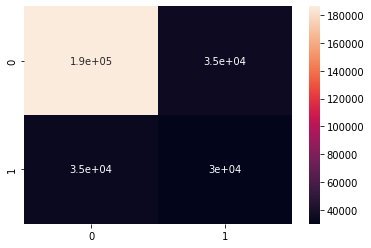

In [14]:
import seaborn as sns 

sns.heatmap(cm, annot = True)